In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils.surround_view import convert_bird_eye_view, blend_bird_eye_img, top_img_to_bird_eye_view_cuda, bottom_img_to_bird_eye_view_cuda, left_img_to_bird_eye_view_cuda, right_img_to_bird_eye_view_cuda

In [2]:
print(cv2.getBuildInformation())


General configuration for OpenCV 4.10.0 =====================================
  Version control:               unknown

  Extra modules:
    Location (extra):            /home/orin/Downloads/opencv_contrib-4.10.0/modules
    Version control (extra):     unknown

  Platform:
    Timestamp:                   2025-01-09T11:33:46Z
    Host:                        Linux 5.15.136-tegra aarch64
    CMake:                       3.22.1
    CMake generator:             Unix Makefiles
    CMake build tool:            /usr/bin/gmake
    Configuration:               Release

  CPU/HW features:
    Baseline:                    NEON FP16
    Dispatched code generation:  NEON_DOTPROD NEON_FP16 NEON_BF16
      requested:                 NEON_FP16 NEON_BF16 NEON_DOTPROD
      NEON_DOTPROD (1 files):    + NEON_DOTPROD
      NEON_FP16 (2 files):       + NEON_FP16
      NEON_BF16 (0 files):       + NEON_BF16

  C/C++:
    Built as dynamic libs?:      YES
    C++ standard:                11
    C++ Compile

In [3]:
front_img = cv2.imread('save_img/front_img.jpg')
front_img = cv2.cvtColor(front_img, cv2.COLOR_RGB2BGR)

left_img = cv2.imread('save_img/left_img.jpg')
left_img = cv2.cvtColor(left_img, cv2.COLOR_RGB2BGR)

right_img = cv2.imread('save_img/right_img.jpg')
right_img = cv2.cvtColor(right_img, cv2.COLOR_RGB2BGR)

rear_img = cv2.imread('save_img/rear_img.jpg')
rear_img = cv2.cvtColor(rear_img, cv2.COLOR_RGB2BGR)

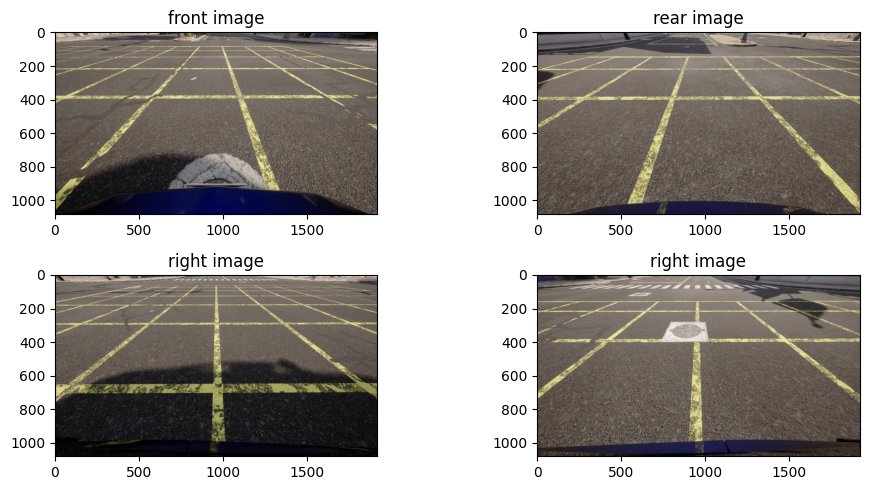

In [4]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)
axis[0, 0].imshow(front_img)
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_img)
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_img)
axis[1, 0].set_title('right image')

axis[1, 1].imshow(right_img)
axis[1, 1].set_title('right image')

plt.tight_layout()

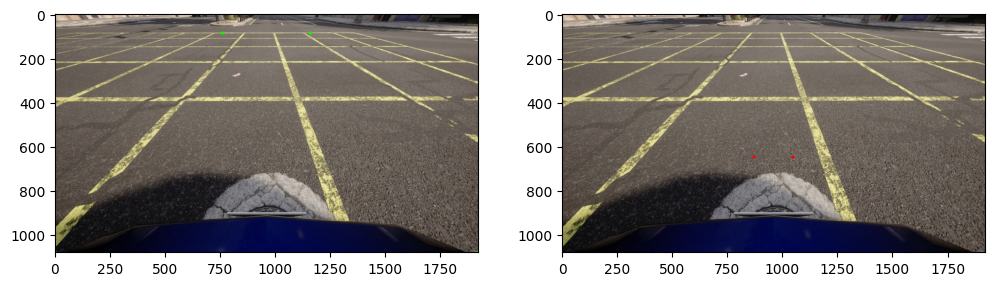

In [5]:
h, w, c = front_img.shape

src_h_ratio = 0.08
src_w_ratio_offset = 0.104

dst_h_ratio = 0.6
dst_w_ratio = 0.0463

src_pts = np.array([[w * (0.5-src_w_ratio_offset), h * src_h_ratio], [w * (0.5+src_w_ratio_offset), h * src_h_ratio], [w, h], [0, h]], dtype=np.float32)
dst_pts = np.array([[w*0.4, 0], [w*0.6, 0], [w*(0.5+dst_w_ratio), h*dst_h_ratio], [w*(0.5-dst_w_ratio), h*dst_h_ratio]], dtype=np.float32)

front_img_copy_1 = front_img.copy()
front_img_copy_2 = front_img.copy()

for pos in src_pts:
    pos = pos.astype(np.int32)
    cv2.circle(img=front_img_copy_1, center=pos, radius=2, color=(0, 255, 0), thickness=10)

for pos in dst_pts:
    pos = pos.astype(np.int32)
    cv2.circle(img=front_img_copy_2, center=pos, radius=2, color=(255, 0, 0), thickness=10)

fig, axis = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
axis[0].imshow(front_img_copy_1)
axis[1].imshow(front_img_copy_2)

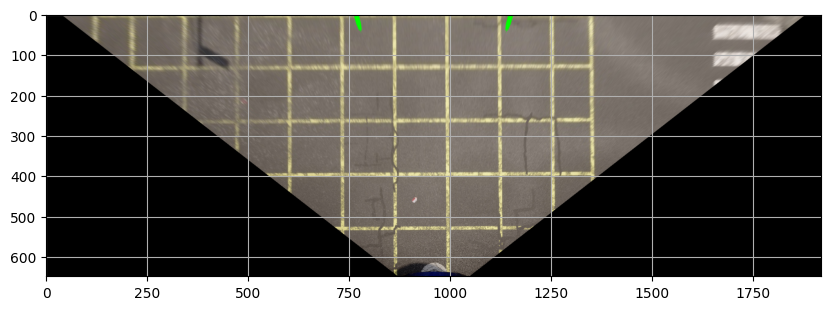

In [6]:
m = cv2.getPerspectiveTransform(src_pts, dst_pts)
dst_img = cv2.warpPerspective(src=front_img_copy_1, M=m, dsize=(w, int(h*dst_h_ratio)), flags=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 10))
plt.grid()
plt.imshow(dst_img)

In [19]:
front_dst = convert_bird_eye_view(front_img)
left_dst = convert_bird_eye_view(left_img)
right_dst = convert_bird_eye_view(right_img)
rear_dst = convert_bird_eye_view(rear_img)

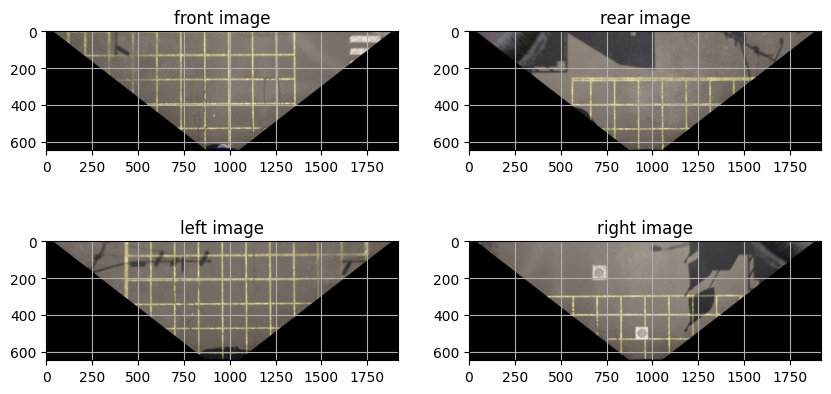

In [20]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)
axis[0, 0].imshow(front_dst)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_dst)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_dst)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_dst)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

dst_img_list = [front_dst, rear_dst, left_dst, right_dst]
dst_img_name_list =['front_dst.jpg', 'rear_dst.jpg','left_dst.jpg', 'right_dst.jpg']

for img_name, img in zip(dst_img_name_list, dst_img_list):
    cv2.imwrite('save_img/'+img_name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [124]:
for i in range(30):
    front_dst = convert_bird_eye_view(front_img)
    left_dst = convert_bird_eye_view(left_img)
    right_dst = convert_bird_eye_view(right_img)
    rear_dst = convert_bird_eye_view(rear_img)

    left_img_rot = cv2.rotate(left_dst, cv2.ROTATE_90_COUNTERCLOCKWISE)
    right_img_rot = cv2.rotate(right_dst, cv2.ROTATE_90_CLOCKWISE)
    rear_img_rot = cv2.rotate(rear_dst, cv2.ROTATE_180)

    result = blend_bird_eye_img(front_dst, left_dst, right_dst, rear_dst)


Text(0.5, 1.0, 'right image')

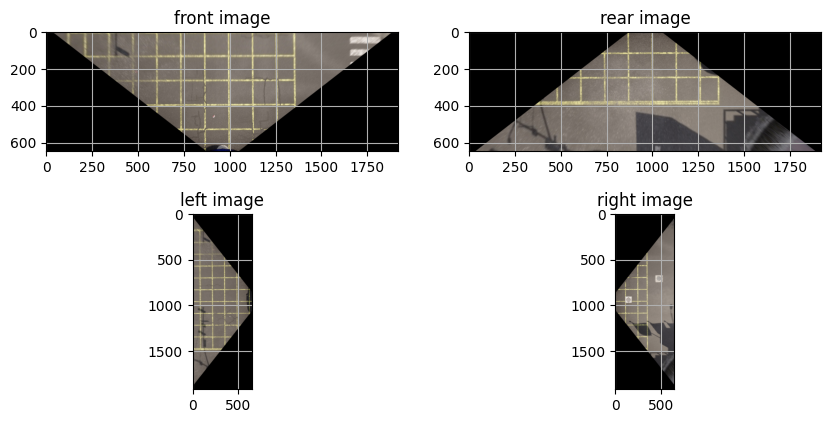

In [110]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 5)

axis[0, 0].imshow(front_dst)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_img_rot)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_img_rot)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_img_rot)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

In [242]:
print(front_img.shape)
print(left_img_rot.shape)

front_img_top_offset = 170
left_img_left_offset = 260
right_img_right_offset = 260

border_color = (0, 0, 0)

front_ext = cv2.copyMakeBorder(front_dst, front_img_top_offset, 1920-(front_dst.shape[0]+front_img_top_offset), 0, 0,
                               cv2.BORDER_CONSTANT, value=border_color)

rear_ext = cv2.copyMakeBorder(rear_img_rot, 1920-(rear_dst.shape[0]+front_img_top_offset), front_img_top_offset, 0, 0,
                              cv2.BORDER_CONSTANT, value=border_color)

left_ext = cv2.copyMakeBorder(left_img_rot, 0, 0, left_img_left_offset, 1920-(left_img_rot.shape[1]+left_img_left_offset),
                               cv2.BORDER_CONSTANT, value=border_color)

right_ext = cv2.copyMakeBorder(right_img_rot, 0, 0, 1920-(right_img_rot.shape[1]+right_img_right_offset), right_img_right_offset,
                               cv2.BORDER_CONSTANT, value=border_color)

(1080, 1920, 3)
(1920, 648, 3)


Text(0.5, 1.0, 'right image')

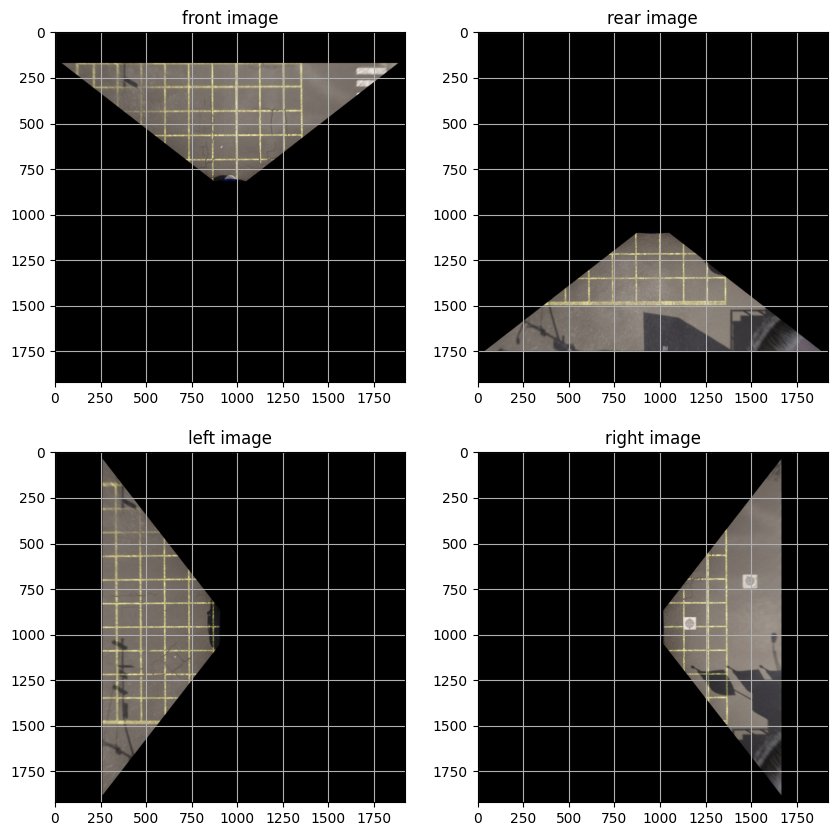

In [243]:
fig, axis = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)

axis[0, 0].imshow(front_ext)
axis[0, 0].grid()
axis[0, 0].set_title('front image')

axis[0, 1].imshow(rear_ext)
axis[0, 1].grid()
axis[0, 1].set_title('rear image')

axis[1, 0].imshow(left_ext)
axis[1, 0].grid()
axis[1, 0].set_title('left image')

axis[1, 1].imshow(right_ext)
axis[1, 1].grid()
axis[1, 1].set_title('right image')

In [231]:
gray = cv2.cvtColor(front_ext, cv2.COLOR_BGR2GRAY)
_, front_img_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

np.min(front_img_mask)

0

In [251]:
blended = cv2.addWeighted(front_ext, 1, left_ext, 1, 0)
blended = cv2.addWeighted(blended, 1, right_ext, 1, 0)
blended = cv2.addWeighted(blended, 1, rear_ext, 1, 0)

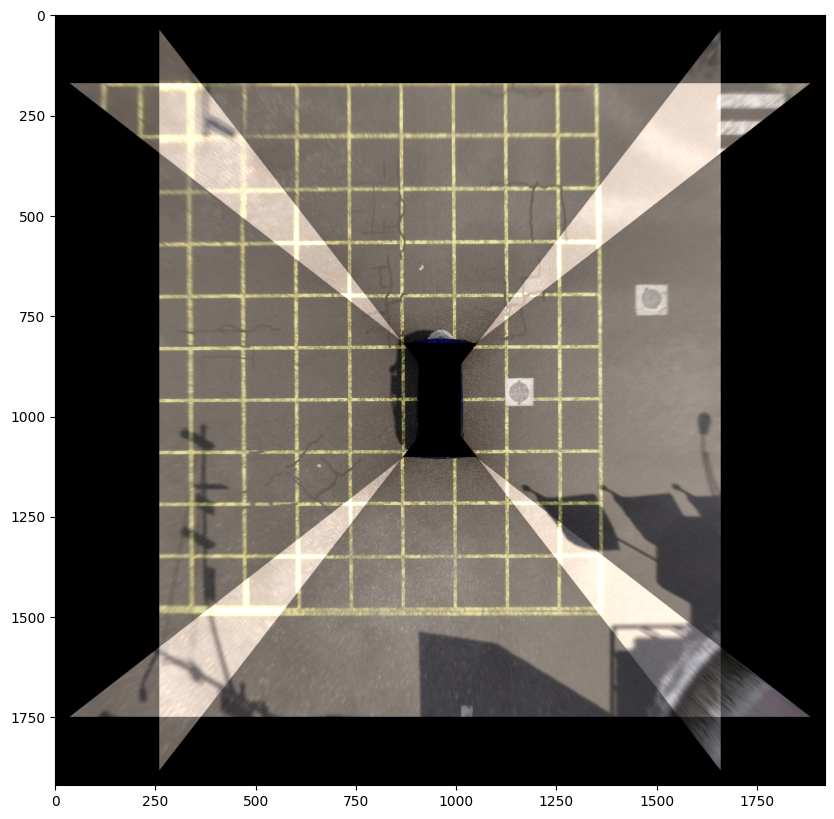

In [252]:
plt.figure(figsize=(10, 10))

plt.imshow(blended)

In [102]:
blender = cv2.detail_FeatherBlender()
blender.setSharpness(0.01)  # Sharpness 조절

w, h = 1920, 1080
dst_roi = (0, 0, int(w * 1.1), int(h * 1.8))

for i in range(30):
    front_dst, front_mask = top_img_to_bird_eye_view_cuda(front_img)
    left_dst, left_mask = left_img_to_bird_eye_view_cuda(left_img)
    right_dst, right_mask = right_img_to_bird_eye_view_cuda(right_img)
    rear_dst, rear_mask = bottom_img_to_bird_eye_view_cuda(rear_img)


    #blender.feed(front_dst, front_mask, (90, 170))  # 첫 번째 이미지
    #blender.feed(left_dst, left_mask, (350, 0))  # 두 번째 이미지
    #blender.feed(right_dst, right_mask, (660, 0))
    #blender.feed(rear_dst, rear_mask, (90, 667))

    #result, result_mask = blender.blend(None, None)
    #result[result < 0] = 0
    #result[result >= 255] = 255

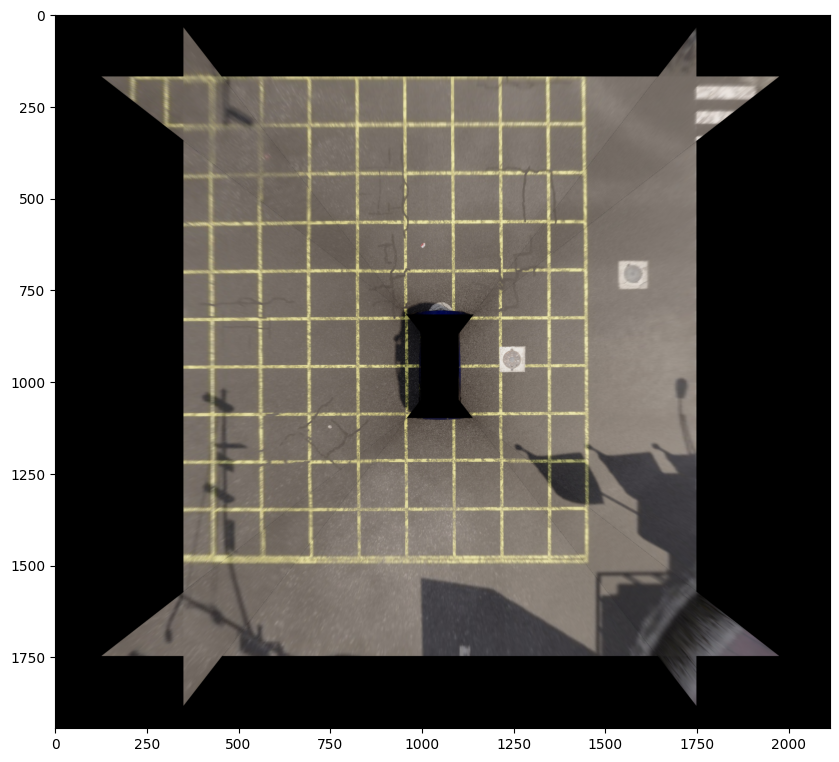

In [125]:
plt.figure(figsize=(10, 10))
plt.imshow(result)

In [80]:
dst_roi

(0, 0, 2112, 1944)

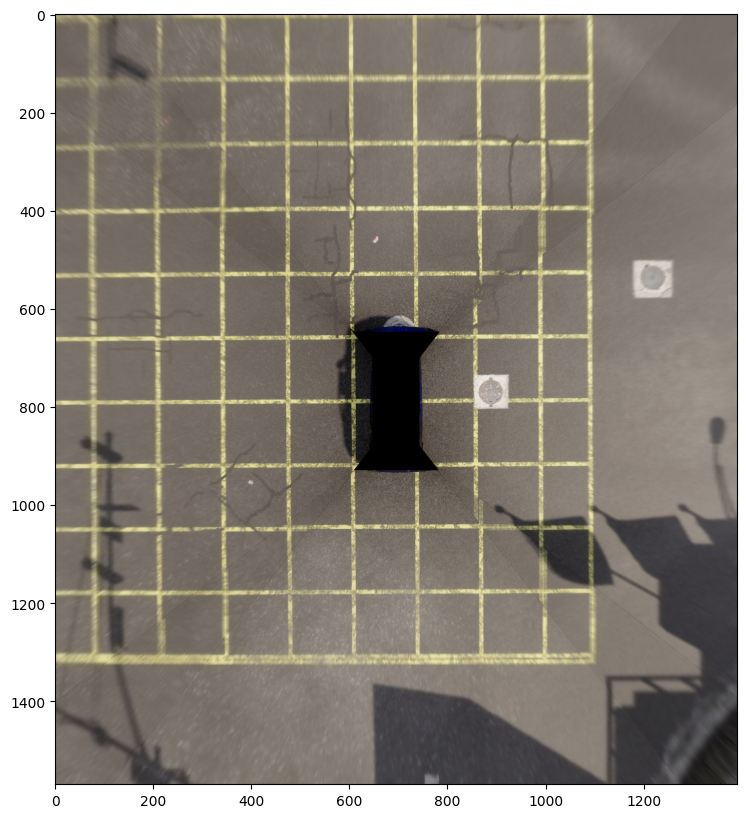

In [81]:
result_1 = result[170:1740, 350:1740]

plt.figure(figsize=(10, 10))
plt.imshow(result_1)